In [19]:
import sys
import os
import numpy as np
import pyranges as pr
import pandas as pd
import snapatac2 as snap
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def filter_peaks(
    peaks: pr.PyRanges,
    blacklist: pr.PyRanges,
    score_col: str = "Score",
    n_peaks: int = None,
    min_q_value: float = None,
) -> pr.PyRanges:
    """Filter peaks based on blacklist regions.

    Performs the following operations:
    1. Remove blacklist regions using PyRanges.overlap(invert=True)
    2. Keep only chr1-22, X, Y
    3. Remove duplicates based on Chromosome, Start, End, keeping row with the highest score_col value

    Parameters
    ----------
    peaks : pr.PyRanges
        Peaks to filter as a PyRanges object.
    blacklist : pr.PyRanges
        Blacklist regions as a PyRanges object.
    
    Returns
    -------
    pr.PyRanges
        Filtered peaks as a PyRanges object.
    """
    # Remove blacklist regions
    peaks = peaks.overlap(blacklist, invert=True)

    # Keep only chr1-22, X, Y
    peaks = peaks[peaks.Chromosome.str.match("chr[1-9]|chr1[0-9]|chr2[0-2]|chrX|chrY")]

    # Remove duplicates based on Chromosome, Start, End, keeping row with the highest score_col value
    peaks_df = peaks.df.sort_values(score_col, ascending=False).drop_duplicates(["Chromosome", "Start", "End"])

    # Remove peaks with q_value > min_q_value. Need to convert min_q_value to 10^-min_q_value
    if min_q_value is not None:
        min_q_value = 10 ** -min_q_value
        peaks_df = peaks_df[peaks_df["q_value"] >= min_q_value]
    
    # Take top n_peaks peaks if specified
    if n_peaks is not None:
        peaks_df = peaks_df.head(n_peaks)


    # Convert back to pyranges
    peaks = pr.PyRanges(peaks_df)

    return peaks

In [30]:
peaks_path = "/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/results/integration/atac/peak_matrices/peak_mat.h5ad"
h5ads_path = "/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/results/integration/atac/annotated.h5ads/_dataset.h5ads"
outdir_path = "/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/results/integration/atac/filtered_peaks"
cellid_colors_path = "/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/ref/cellid_colors.csv"

In [31]:
# Load cell id colors
cellid_colors = pd.read_csv(cellid_colors_path, index_col=0, header=None)
cellid_colors = cellid_colors.to_dict()[1]
cellid_colors

{'beta_1': '#0d8101',
 'beta_2': '#00ff00',
 'alpha_1': '#8b1200',
 'alpha_2': '#ff0000',
 'delta_1': '#fd8e02',
 'delta_2': '#ff7f00',
 'gamma': '#800780',
 'epsilon': '#b360cf',
 'ductal': '#a7a7a7',
 'acinar': '#010101',
 'stellate': '#88ccea',
 'activated_stellate': '#4a91c7',
 'quescient_stellate': '#c0e4f3',
 'endothelial': '#5077e0',
 'schwann': '#f4ca16',
 'mast': '#ff6347',
 'immune': '#0700ff',
 'other': '#ff00ff'}

In [3]:
# Path to blacklist
blacklist_path = "/cellar/users/aklie/data/ref/genomes/hg38/blacklist/blacklist.bed.gz"
blacklist = pr.read_bed(blacklist_path)
blacklist

,Chromosome,Start,End
0,chr1,628903,635104
1,chr1,5850087,5850571
2,chr1,8909610,8910014
3,chr1,9574580,9574997
4,chr1,32043823,32044203
...,...,...,...
905,chrY,11290797,11334278
906,chrY,11493053,11592850
907,chrY,11671014,11671046
908,chrY,11721528,11749472


In [12]:
# Read in h5ad file
adataset = snap.read_dataset(h5ads_path)
adata = adataset.to_adata()
adataset.close()
adata

AnnData object with n_obs × n_vars = 12806 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'annotation'
    var: 'count', 'selected'
    uns: 'macs3', 'AnnDataSet', 'spectral_eigenvalue', 'reference_sequences'
    obsm: 'X_umap', 'X_spectral'
    obsp: 'distances'

In [13]:
# Load peak data
adata_peaks = snap.read(peaks_path, backed=None)
adata_peaks

AnnData object with n_obs × n_vars = 12806 × 492079
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'annotation'

In [18]:
# Params
min_q_value = [None]
n_peaks = [None, 150_000]
     

# make filter dir
os.makedirs(outdir_path, exist_ok=True)

In [15]:
# Get peaks
peaksets = adata.uns["macs3"].copy()

# Rename chrom:Chromosome, start:Start, end:End
for k, v in peaksets.items():
    v = v.to_pandas()
    peaksets[k] = v.rename(columns={"chrom": "Chromosome", "start": "Start", "end": "End"})

In [20]:
# For each filtering parameter
for q_val in min_q_value:
    for n_peak in n_peaks:
        
        # Convert each df in the dict to a PyRanges object
        peaksets_pr = {k: pr.PyRanges(v) for k, v in peaksets.items()}

        # Filter peaks
        for k, v in peaksets_pr.items():
            peaksets_pr[k] = filter_peaks(v, blacklist, score_col="q_value", n_peaks=n_peak, min_q_value=q_val)

        # Save filtered peaks
        for k, v in peaksets_pr.items():
            filename = f"{k}.filt"
            if q_val is not None:
                filename += f".q{q_val}"
            if n_peak is not None:
                filename += f".n{n_peak}"
            filename += ".narrowPeak"
            v.to_bed(os.path.join(outdir_path, filename))

        # Rename back from chrom:Chromosome, start:Start, end:End and turn into polars dataframes
        peaksets_pl = {}
        for k, v in peaksets_pr.items():
            v = v.df.rename(columns={"Chromosome": "chrom", "Start": "start", "End": "end"})
            v["chrom"] = v["chrom"].astype(str)
            v["start"] = v["start"].astype(np.uint64)
            v["end"] = v["end"].astype(np.uint64)
            peaksets_pl[k] = pl.DataFrame(v)

        # Merge peaks
        filtered_consensus = snap.tl.merge_peaks(
            peaks=peaksets_pl,
            chrom_sizes=snap.genome.hg38
        )
    
        # Clean up 
        filtered_consensus_df = filtered_consensus.to_pandas().set_index("Peaks")
        filtered_consensus_df["exists_in"] = filtered_consensus_df.apply(
            lambda x: ", ".join([k for k, v in x.items() if v]), axis=1
        )
        filtered_consensus_df["chrom"] = filtered_consensus_df.index.str.split(":").str[0]
        filtered_consensus_df["start"] = filtered_consensus_df.index.str.split(":").str[1].str.split("-").str[0].astype(np.uint64)
        filtered_consensus_df["end"] = filtered_consensus_df.index.str.split(":").str[1].str.split("-").str[1].astype(np.uint64)

        # Save
        filename = "consensus.filt"
        if q_val is not None:
            filename += f".q{q_val}"
        if n_peak is not None:
            filename += f".n{n_peak}"
        filename += ".bed"
        filtered_consensus_df[['chrom', 'start', 'end', 'exists_in']].to_csv(os.path.join(outdir_path, filename), sep="\t", header=False, index=False)

# Get total counts per cell type

In [25]:
adata_peaks

AnnData object with n_obs × n_vars = 12806 × 492079
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'annotation'

In [37]:
# For each celltype in "annotation" count up counts in .X
celltype_counts = {}
for celltype in adata.obs["annotation"].unique():
    celltype_counts[celltype] = adata[adata.obs["annotation"] == celltype].X.sum()

In [39]:
celltype_counts

{'alpha_2': 7025782,
 'beta_2': 23741854,
 'immune': 391536,
 'alpha_1': 38599700,
 'beta_1': 32934848,
 'delta_2': 1445506,
 'delta_1': 2673264,
 'ductal': 380174,
 'acinar': 235864,
 'stellate': 1078004,
 'gamma': 1596154,
 'endothelial': 540850}

/tmp/ipykernel_819219/978696219.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="counts", y=counts_df.index, data=counts_df, palette=cellid_colors)


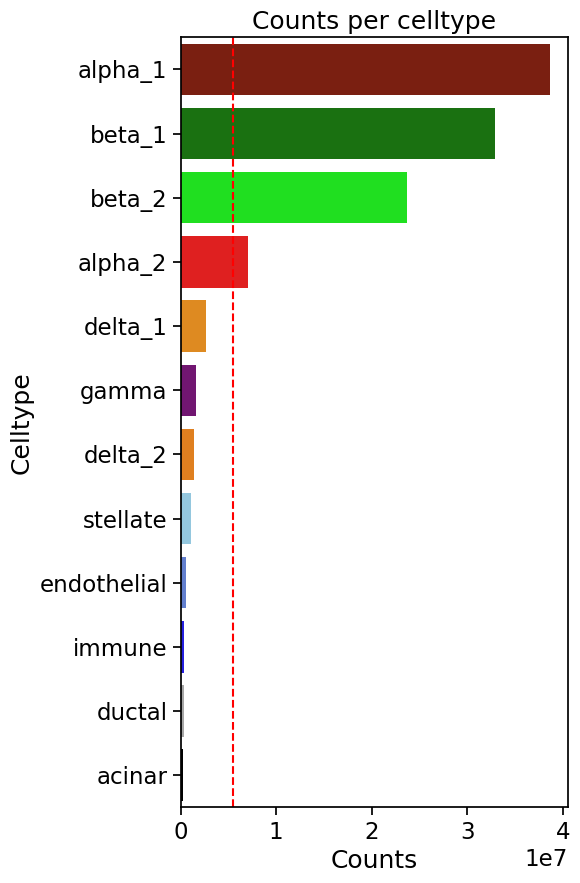

In [45]:
# Plot as a nice horizontal barplot, order from highest to lowest and match up with cellid_colors
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(5, 10))
    counts_df = pd.DataFrame(celltype_counts, index=["counts"]).T.sort_values("counts", ascending=False)
    sns.barplot(x="counts", y=counts_df.index, data=counts_df, palette=cellid_colors)
    ax.set_xlabel("Counts")
    ax.set_ylabel("Celltype")
    ax.set_title("Counts per celltype")
    ax.axvline(5_500_000, color="red", linestyle="--")
    plt.show()

# DONE!

---